#Hyperparameters

In [0]:
IMAGE_SIZE = 64
EPOCHS = 50
BATCH_SIZE = 64
DATASET_FOLDER = 'simpsons_input/'
LR_D = 0.00004
LR_G = 0.0004
BETA1 = 0.5
WEIGHT_INIT_STDDEV = 0.02
EPSILON = 0.00005

#Imports

In [0]:
from datetime import datetime
import os
from glob import glob
from IPython import display
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import PIL
from PIL import Image
import pytz
tz_NY = pytz.timezone('America/New_York') 
import random
from scipy import ndarray
import skimage as sk
from skimage import io
from skimage import util
from skimage import transform
import tensorflow as tf
from tensorflow.keras import layers
import time

#Image presentation functions

In [0]:
def generate_and_save_images(model, epoch, test_input, save_image=True):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      generated_image2 = predictions[i].numpy() * 127.5 + 127.5
      plt.imshow(generated_image2.astype('uint8'))

      plt.axis('off')

  if save_image:
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:
def show_samples(sample_images):
    
    print("len(sample_images): ", len(sample_images))
    print("len(sample_images): ", sample_images[0].shape)
    
    figure, axes = plt.subplots(1, len(sample_images), figsize = (50, 50))

    print("figure: ", figure)
    print("axes: ", axes)

    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)
        
    plt.show()
    plt.close()

In [0]:
def show_image_custom(input_image):
    fig = plt.figure(figsize=(4,4))

    plt.imshow(input_image)

    plt.axis('off')

    plt.show()

In [0]:
def show_samples2(sample_images):
    figure, axes = plt.subplots(1, len(sample_images), figsize = (50, 50))

    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        image_array = image_array.numpy() * 127.5 + 127.5
        axis.imshow(image_array.astype(np.uint8))

    plt.show()
    plt.close()

# Data Preparation

In [7]:
from google.colab import drive
drive.mount('/content/drive')
ZIP_FILE = '/content/drive/My\ Drive/UoT/Assignment4/simpsons-faces.zip'
!cp $ZIP_FILE .    
!unzip -q -o 'simpsons-faces.zip'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from shutil import copytree, ignore_patterns

# remove the images that don't have characters
def prepareDataset(src, dst):
    if not os.path.exists(src):
        os.makedirs(src)
    copytree(src, dst, ignore=ignore_patterns("9746.*","9731.*","9717.*","9684.*","9637.*","9641.*","9642.*","9584.*","9541.*","9535.*",
"9250.*","9251.*","9252.*","9043.*","8593.*","8584.*","8052.*","8051.*","8008.*","7957.*",
"7958.*","7761.*","7762.*","9510.*","9307.*","4848.*","4791.*","4785.*","4465.*","2709.*",
"7724.*","7715.*","7309.*","7064.*","7011.*","6961.*","6962.*","6963.*","6960.*","6949.*",
"6662.*","6496.*","6409.*","6411.*","6406.*","6407.*","6170.*","6171.*","6172.*","5617.*",
"4363.*","4232.*","4086.*","4047.*","3894.*","3889.*","3493.*","3393.*","3362.*","2780.*",
"2710.*","2707.*","2708.*","2711.*","2712.*","2309.*","2056.*","1943.*","1760.*","1743.*",
"1702.*","1281.*","1272.*","772.*","736.*","737.*","691.*","684.*","314.*","242.*","191.*"))

prepareDataset('./cropped', DATASET_FOLDER)

Input: (9796, 64, 64, 3)
len(sample_images):  5
len(sample_images):  (64, 64, 3)
figure:  Figure(3600x3600)
axes:  [<matplotlib.axes._subplots.AxesSubplot object at 0x7f91172a9e48>


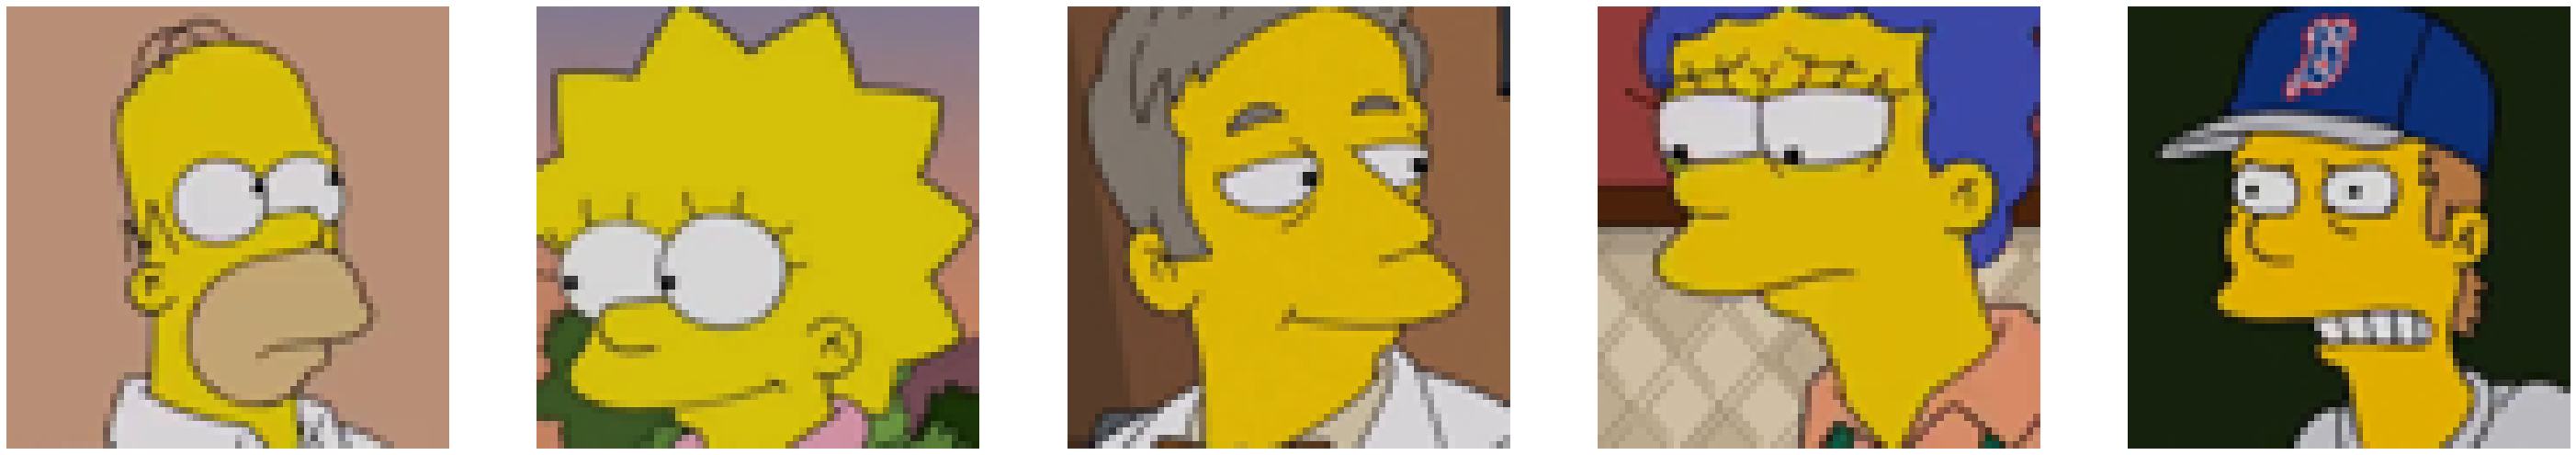

In [9]:
input_images = np.asarray([np.asarray(
    Image.open(file)
    .resize((IMAGE_SIZE, IMAGE_SIZE))
    ) for file in glob(DATASET_FOLDER+'*')])
print ("Input: " + str(input_images.shape))

np.random.shuffle(input_images)

sample_images = input_images[:5]
show_samples(sample_images)


In [0]:
train_images = input_images.reshape(input_images.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5 

# Batch and shuffle the data
BUFFER_SIZE = input_images.shape[0]
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Generator

In [0]:
def make_generator_model():

    model = tf.keras.Sequential()
    
    # 4x4x1024
    model.add(layers.Dense(4*4*1024, input_shape=(100,)))
    model.add(layers.Reshape((4, 4, 1024)))
    model.add(layers.LeakyReLU())
        
    # 4x4x1024 -> 8x8x512
    model.add(layers.Conv2DTranspose(512, 
                                     (5, 5), 
                                     strides=(2, 2), 
                                     padding='same',
                                     kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)
                                    ))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU())
        
    # 8x8x512 -> 16x16x256
    model.add(layers.Conv2DTranspose(256, 
                                     (5, 5), 
                                     strides=(2, 2), 
                                     padding='same', 
                                     kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU())

    # 16x16x256 -> 32x32x128
    model.add(layers.Conv2DTranspose(128, 
                                     (5, 5), 
                                     strides=(2, 2), 
                                     padding='same', 
                                     kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU())
    
    # 32x32x128 -> 64x64x64
    model.add(layers.Conv2DTranspose(64, 
                                     (5, 5), 
                                     strides=(2, 2), 
                                     padding='same', 
                                     kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU())    

    # 64x64x64 -> 64x64x3
    model.add(layers.Conv2DTranspose(3, 
                                     (5, 5), 
                                     strides=(1, 1), 
                                     padding='same', 
                                     kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),
                                     activation='tanh'))
    
    return model

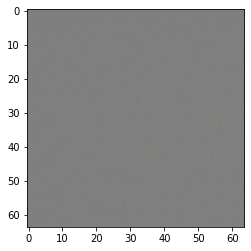

In [12]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

generated_image2 = generated_image[0].numpy() * 127.5 + 127.5

plt.imshow(generated_image2.astype('uint8'))

# Discriminator

In [0]:
def make_discriminator_model():
    
    model = tf.keras.Sequential()
    # 64*64*3 -> 32x32x64 
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU())

    # 32x32x64-> 16x16x128 
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same',
                                     kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU())

    # 16x16x128 -> 8x8x256  
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same',
                                     kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU())

    # 8x8x256 -> 8x8x512
    model.add(layers.Conv2D(512, (5, 5), strides=(1, 1), padding='same',
                                     kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU())
    
    # 8x8x512 -> 4x4x1024
    model.add(layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same',
                                     kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU())
    
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [14]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49988815]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

In [0]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Define the training loop


In [0]:
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
def summarize_epoch(epoch, d_losses, g_losses, save_image=True):
  
    fig, ax = plt.subplots()
    plt.plot(d_losses, label='Discriminator', alpha=0.6)
    plt.plot(g_losses, label='Generator', alpha=0.6)
    plt.title("Losses")
    plt.legend()
    if save_image:
        plt.savefig("losses_" + str(epoch) + ".png")
    plt.show()
    plt.close()
    

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [0]:
def train(dataset, epochs):
  print('Training started at: ', datetime.now(tz_NY))
  save_image = False
  d_losses = []
  g_losses = []
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      d_loss, g_loss = train_step(image_batch)
      d_losses.append(d_loss)
      g_losses.append(g_loss)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    

    # Save the model every 15 epochs
    if (epoch + 1) % 30 == 0:
      save_image = True

    generate_and_save_images(generator,
                             epoch + 1,
                             seed,
                             save_image)
    summarize_epoch(epoch, d_losses, g_losses, save_image)
    save_image = False
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  summarize_epoch(epoch, d_losses, g_losses)

  

## Train the model

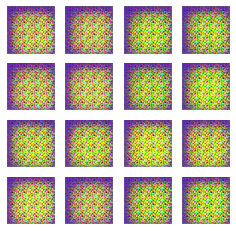

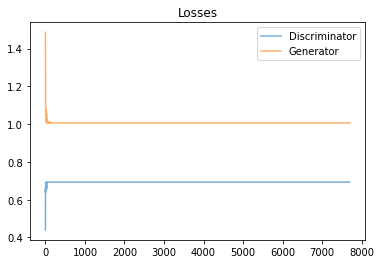

In [23]:
train(train_dataset, EPOCHS)

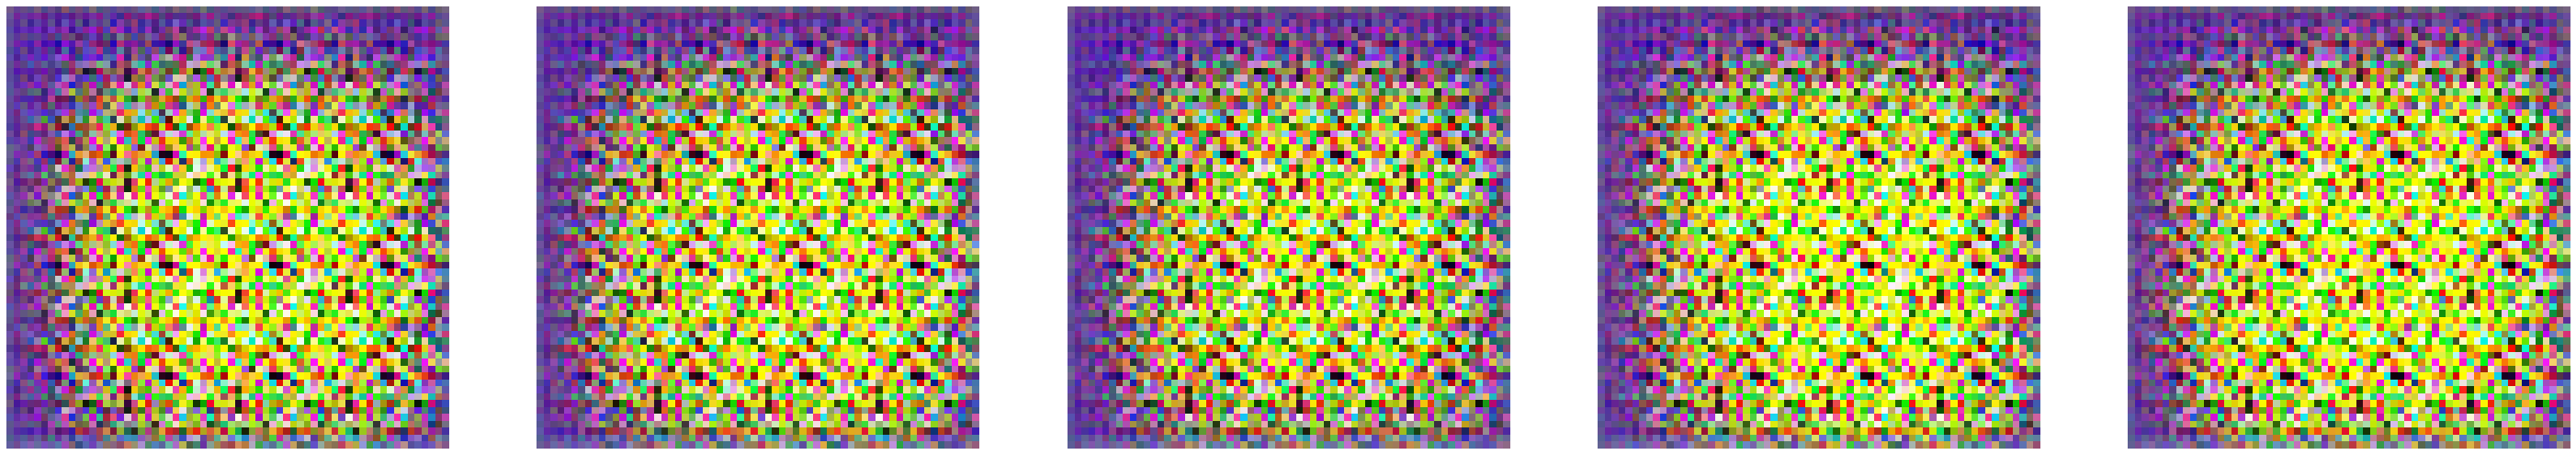

In [24]:
noise = tf.random.normal([5, 100])
generated_image = generator(noise, training=False)
show_samples2(generated_image)

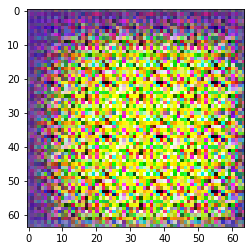

In [25]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image2 = generated_image[0].numpy() * 127.5 + 127.5

plt.imshow(generated_image2.astype(np.uint8))
plt.show()
plt.close()

## Create a GIF


In [0]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

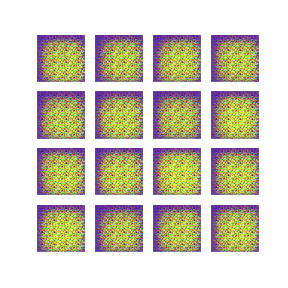

In [27]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

If you're working in Colab you can download the animation with the code below:

In [0]:
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download(anim_file)